## Ishihara vision test plates generator
Inspired from [franciscouzo](https://franciscouzo.github.io)

In [1]:
import math
import random
import numpy as np
import sys
import os
import glob
from PIL import Image, ImageDraw
from tqdm import tqdm
from scipy.spatial import cKDTree as KDTree

TOTAL_CIRCLES = 1500

BACKGROUND = (255, 255, 255)

COLORS_ON = [
    (249, 187, 130), (235, 161, 112), (252, 205, 132)
]

COLORS_OFF = [
    (156, 165, 148), (172, 180, 165), (187, 185, 100),
    (215, 218, 170), (229, 213, 125), (209, 214, 175)
] 

In [2]:
def generate_circle(image_width, image_height, min_diameter, max_diameter):
    radius = random.triangular(min_diameter, 
                               max_diameter,
                               max_diameter * 0.8 + min_diameter * 0.2) / 2

    angle = random.uniform(0, math.pi * 2)
    distance_from_center = random.uniform(0, image_width * 0.48 - radius)
    x = image_width  * 0.5 + math.cos(angle) * distance_from_center
    y = image_height * 0.5 + math.sin(angle) * distance_from_center
    return x, y, radius

In [3]:
def overlaps_motive(image, circle):
    x, y, r = circle[0], circle[1], circle[2]
    # Boundary violation 
    vb = 2
    points_x = [x, x, x, x-r, x+r, x-r*vb, x-r*vb, x+r*vb, x+r*vb]
    points_y = [y, y-r, y+r, y, y, y+r*vb, y-r*vb, y+r*vb, y-r*vb]

    for x, y in zip(points_x, points_y):
        if image.getpixel((x,y))[:3] != BACKGROUND:
            return True
    return False

In [4]:
def circle_intersection(circl_1, circl_2):
    x1, y1, r1 = circl_1[0], circl_1[1], circl_1[2]
    x2, y2, r2 = circl_2[0], circl_2[1], circl_2[2]
    return (x2 - x1)**2 + (y2 - y1)**2 < (r2 + r1)**2

In [5]:
def circle_draw(draw_image, image, circle):
    x, y, r = circle[0], circle[1], circle[2]
    fill_colors = COLORS_ON if overlaps_motive(image, (x, y, r)) else COLORS_OFF
    fill_color = random.choice(fill_colors)
    draw_image.ellipse((x - r, y - r, x + r, y + r), fill=fill_color, outline=fill_color)

In [8]:
def generate_ish(path):
    fname = path.split("/")[-1].split("-")[0]
    img_in = Image.open(path)
    img_out = Image.new('RGB', img_in.size, BACKGROUND)
    draw_image = ImageDraw.Draw(img_out)
    width, height = img_in.size
    min_diameter = (width + height) / 200
    max_diameter = (width + height) / 75

    # Create circle 
    circle = generate_circle(width, height, min_diameter, max_diameter)
    circles = [circle]

    circle_draw(draw_image, img_in, circle)

    for i in tqdm(range(TOTAL_CIRCLES)):
        tries = 0
        kdtree = KDTree([(x, y) for (x, y, _) in circles])
        while True:
            circle = generate_circle(width, height, min_diameter, max_diameter)
            elements, indexes = kdtree.query([(circle[0], circle[1])], k=4)
            for element, index in zip(elements[0], indexes[0]):
                if not np.isinf(element) and circle_intersection(circle, circles[index]):
                    break
            else:
                break
            tries += 1

        circles.append(circle)
        circle_draw(draw_image, img_in, circle)

#     img_out.show()
    out_path = path.split('/')[:-1]
    img_out.save(f"{os.path.join(*out_path, fname + '-out.png')}", "PNG")

100%|██████████| 1500/1500 [00:10<00:00, 139.64it/s]


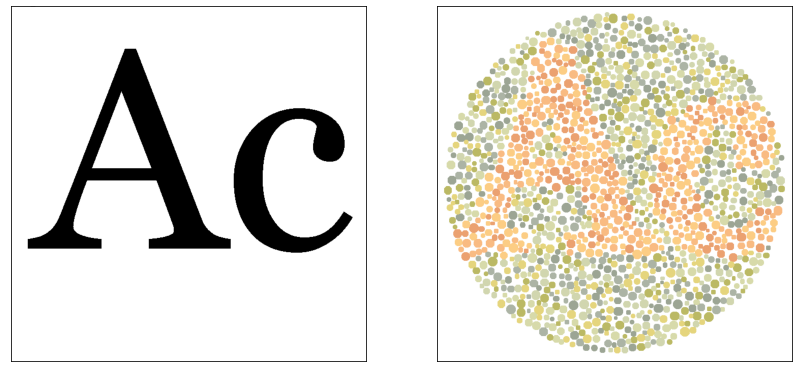

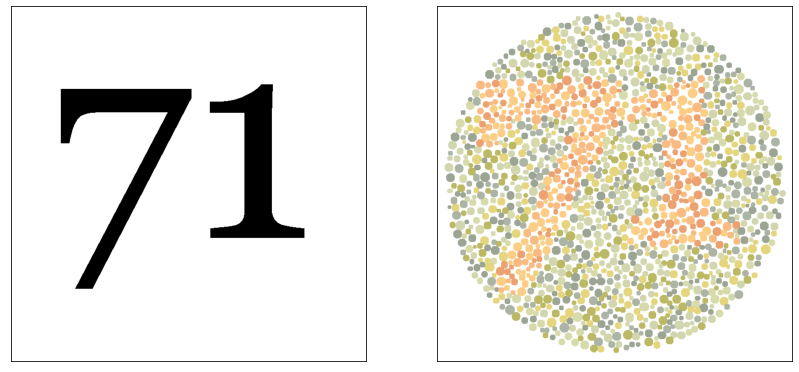

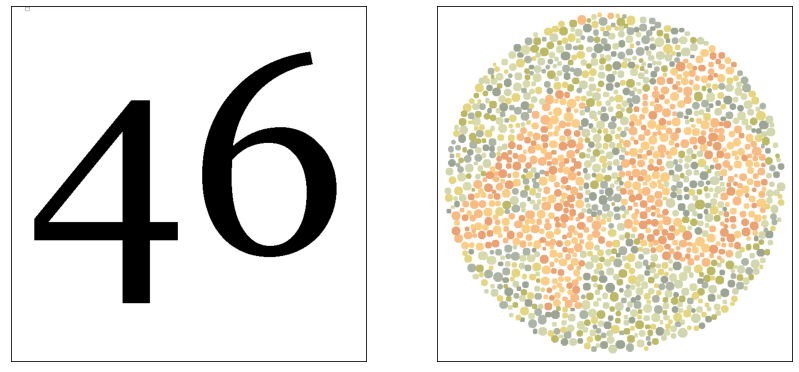

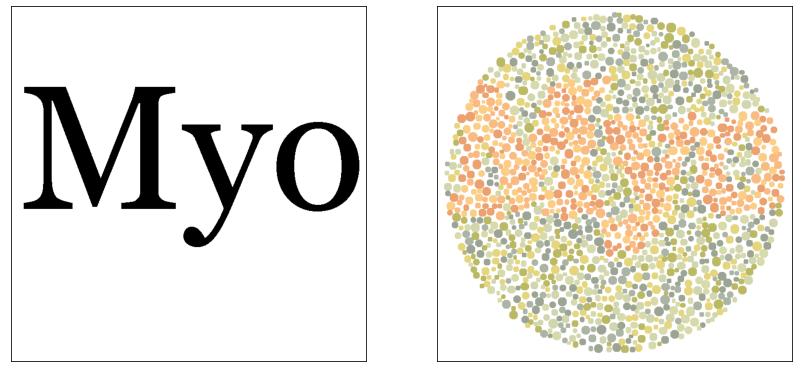

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for file in glob.glob("datasets/ishihara/*-in.png"):
    generate_ish(file)
    
def visualize(image_file, test_file):
    f, ax = plt.subplots(1, 2, figsize=(14, 12))
    ax[0].imshow(image_file)
    ax[0].set_title('')
    ax[0].grid(False)
    ax[0].axes.xaxis.set_visible(False)
    ax[0].axes.yaxis.set_visible(False)
    plt.grid(False)

    ax[1].imshow(test_file)
    ax[1].set_title('')
    ax[1].grid(False)
    ax[1].axes.xaxis.set_visible(False)
    ax[1].axes.yaxis.set_visible(False)
    plt.grid(False)

for file in glob.glob("datasets/ishihara/*-in.png"):
    fname = file.split("/")[-1].split("-")[0]
    image_file = mpimg.imread(f"datasets/ishihara/{fname}-in.png")
    test_file = mpimg.imread(f"datasets/ishihara/{fname}-out.png")
    visualize(image_file, test_file)
    
    del image_file, test_file 
    
